In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.autograd import Variable
import numpy as np

np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

# load data

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, num_workers=2, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, num_workers=2, shuffle=True)

# train

In [60]:
def squash(input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return output_tensor

In [61]:
class PrimaryCaps(nn.Module):
    def __init__(self, in_channels=256, out_channels=32, num_caps=8):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList([nn.Conv2d(
            in_channels, out_channels, kernel_size=9, stride=2, padding=0) for _ in range(num_caps)])

    def forward(self, x):
        u = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
        u = torch.cat(u, dim=-1)
        return squash(u)

In [62]:
class DigitCaps(nn.Module):
    def __init__(self, in_channels=8, out_channels=16, num_route_nodes=32*6*6, num_classes=10, num_iters=3):
        super(DigitCaps, self).__init__()
        self.num_iters = num_iters
        self.weights = nn.Parameter(torch.randn(num_classes, num_route_nodes, in_channels, out_channels))

    def forward(self, x):
        # weightのNoneはbatch_sizeに対応するための行列変形
        # xのは前から出力クラス，各capsuleに対する重みの数に対応
        # weights[:, None, :, :, :].shape == [10, 1, 1152, 1, 16]
        # x[None, :, :, None, :].shape == [1, batch_size, 1152, 1, 8]
        u_ = torch.matmul(x[None, :, :, None, :], self.weights[:, None, :, :, :])
#         b = Variable(torch.zeros(*u_.shape))
        b = Variable(torch.zeros(*u_.shape)).cuda()
        
        # routing alg.
        for i in range(self.num_iters):
            c = F.softmax(b, dim=2)
            s = torch.mul(u_, c).sum(dim=2, keepdim=True)
            v = squash(s)
            
            if i < self.num_iters-1:
                b = b + torch.mul(u_, c).sum(dim=-1, keepdim=True)
                
        return v.squeeze().transpose(0, 1)
    # [10, 256, 1, 1, 16] -> [256, 10, 16]

In [63]:
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CapsuleNet, self).__init__()
        self.num_classes = num_classes
        self.conv = nn.Conv2d(1, 256, kernel_size=9)
        self.primary_caps = PrimaryCaps()
        self.disit_caps = DigitCaps()
        
        self.decoder = nn.Sequential(nn.Linear(16*self.num_classes, 512),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, 1024),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(1024, 28*28),
                                     nn.Sigmoid())
        
    def forward(self, x, y=None):
        # [batch_size, 1, 28, 28]
        x = self.conv(x)
        x = F.relu(x, inplace=True)
        # [batch_size, 256, 20, 20]
        x = self.primary_caps(x)
        # [batch_size, 1152, 8]
        x = self.disit_caps(x)
        # [10, batch_size, 16]
        
        cls = torch.sqrt((x**2).sum(dim=-1))
        cls = F.softmax(cls, dim=-1)
        
        if y is None:
            _, idx = cls.max(dim=1)
#             y = Variable(torch.eye(10)).index_select(dim=0, index=idx)
            y = Variable(torch.eye(10)).cuda().index_select(dim=0, index=idx)
        
        reconstr = self.decoder(torch.mul(x, y[:, :, None]).view(x.size(0), -1))
    
        return cls, reconstr

In [64]:
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.mse_loss = nn.MSELoss(size_average=False)
        
    def margin_loss(self, pred, y_true):
        left = F.relu(0.9-pred, inplace=True) ** 2
        right = F.relu(pred-0.1, inplace=True) ** 2
        margin_loss = y_true * left + 0.5 * (1. - y_true) * right
        return margin_loss.sum()

    def reconstr_loss(self, reconstr, org_data):
        return self.mse_loss(reconstr, org_data) * 0.0005

    def forward(self, org_data, y_true, pred, reconstr):
        org_data = org_data.view(reconstr.size(0), -1)
        margin_loss = self.margin_loss(pred, y_true)
        reconstr_loss = self.reconstr_loss(reconstr, org_data)
        return (margin_loss + reconstr_loss) / org_data.size(0)

In [65]:
model = CapsuleNet()
model.cuda()

CapsuleNet(
  (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primary_caps): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (disit_caps): DigitCaps(
  )
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [66]:
optimizer = optim.Adam(model.parameters())
loss_func = CapsuleLoss().cuda()

def train(train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
#         x, y = x.cuda(), y.cuda()
#         b_x = Variable(x)
#         b_y = Variable(torch.eye(10).index_select(dim=0, index=y))

        b_x = Variable(x).cuda()
        b_y = Variable(torch.eye(10).index_select(dim=0, index=y)).cuda()
        
        
        optimizer.zero_grad()
        outputs, reconstr = model(b_x, b_y)
        
        loss = loss_func(b_x, b_y, outputs, reconstr)
        train_loss += loss.data[0]

        loss.backward()
        optimizer.step()
        
        
        if batch_idx % 100 == 0:
            print("train accuracy:", sum(np.argmax(outputs.data.cpu().numpy(), 1) == 
                                   np.argmax(b_y.data.cpu().numpy(), 1)) / 256.)
        

    train_loss = train_loss / len(train_loader)
    return train_loss

def valid(test_loader):
    model.eval()
    test_loss = 0
    for batch_idx, (x, y) in enumerate(test_loader):
#         x, y = x.cuda(), y.cuda()
#         b_x = Variable(x, volatile=True)
#         b_y = Variable(torch.eye(10).index_select(dim=0, index=y), volatile=True)
        
        b_x = Variable(x, volatile=True).cuda()
        b_y = Variable(torch.eye(10).index_select(dim=0, index=y), volatile=True).cuda()
        
        outputs, reconstr = model(b_x)
        loss = loss_func(b_x, b_y, outputs, reconstr)
        test_loss += loss.data[0]
        
        if batch_idx % 100 == 0:
            print("test accuracy:", sum(np.argmax(outputs.data.cpu().numpy(), 1) == 
                                   np.argmax(b_y.data.cpu().numpy(), 1)) / 256.)

    val_loss = test_loss / len(test_loader)
    return val_loss

In [67]:
epochs = 3
loss_list = []
val_loss_list = []
for epoch in range(epochs):
    loss = train(train_loader)
    val_loss = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f'
          % (epoch, loss, val_loss))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)

train accuracy: 0.0859375
train accuracy: 0.92578125
train accuracy: 0.95703125
test accuracy: 0.94140625
epoch 0, loss: 0.8451 val_loss: 0.7832
train accuracy: 0.97265625
train accuracy: 0.96875
train accuracy: 0.96484375
test accuracy: 0.9921875
epoch 1, loss: 0.7668 val_loss: 0.7560
train accuracy: 0.96875
train accuracy: 0.96484375
train accuracy: 0.97265625
test accuracy: 0.984375
epoch 2, loss: 0.7481 val_loss: 0.7442


In [13]:
x, y = iter(test_loader).next()
b_x = Variable(x, volatile=True).cuda()
b_y = Variable(torch.eye(10).index_select(dim=0, index=y), volatile=True).cuda()

outputs, reconstr = model(b_x)

In [101]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    for i in range(5):
        fig = plt.figure()
        for j in range(1, 6):
            ax = fig.add_subplot(1, 5, j)
            ax.matshow(images[i*5+j-1], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
        plt.show()

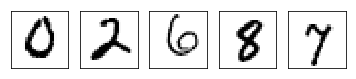

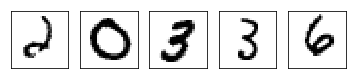

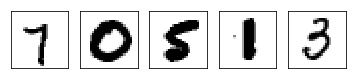

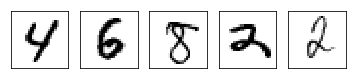

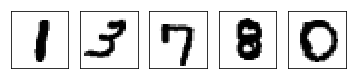

In [102]:
plot_images_separately(b_x[:25,0].data.cpu().numpy())

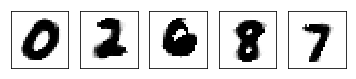

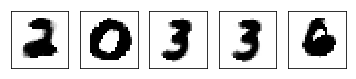

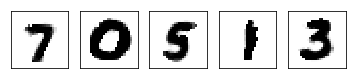

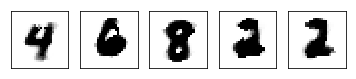

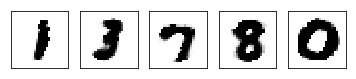

In [103]:
plot_images_separately(reconstr.view(b_x.shape)[:25,0].data.cpu().numpy())